In [69]:
from data_utils import extract_rectangles_from_xml
import cv2
from tqdm import tqdm
import numpy as np
import os
from matplotlib import pyplot as plt
import csv
%matplotlib inline

## Create dataset (From video to image/labels folder)
Ultralytics requires an specific dataset folder structure. It also requires the train.txt and test.txt files, but these are created in "run_experiments.py", before running the model.

In [59]:
cap = cv2.VideoCapture('data/AICity_data/train/S03/c010/vdo.avi')
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

annotation = extract_rectangles_from_xml('data/ai_challenge_s03_c010-full_annotation.xml')
gt_bbox = [
    [list(np.array(r).astype(int)) for r in rect]
    for rect in list(annotation.values())
]

dataset_folder = "data/sequence_dataset"
os.makedirs(dataset_folder+"/images", exist_ok=True)
os.makedirs(dataset_folder+"/labels", exist_ok=True)

frame_detections = []
for id in tqdm(range(n_frames)):
    if not cap.isOpened():
        break
    ret, frame = cap.read()
    name = str(id)+".png"
    
    # save the image
    cv2.imwrite(os.path.join(dataset_folder, "images", name), frame)

    with open(f"{dataset_folder}/labels/{str(id)}.txt", "w+") as f:
        # Each line is formed by: cls_id c_x c_y w h
        #   cls_id is the class ID, (c_x, c_y) is the center of the bbox and w/h the width/height of the bbox
        f.writelines(
            [ f"{0} {(bbox[0]/width + bbox[2]/width)/2} {(bbox[1]/height + bbox[3]/height)/2} {(bbox[2]-bbox[0])/width} {(bbox[3]-bbox[1])/height}\n"
                for bbox in gt_bbox[id]
            ])
        

100%|██████████| 2141/2141 [02:37<00:00, 13.59it/s]


## Create Train/Validation loss curves plot

In [62]:
box_weight, cls_weight, dfl_weigth = 7.5, 0.5, 1.5
train_losses, val_losses = [], []
# A results.csv file is automatically generated at the end of the training
with open("results/strategy_A/results.csv", newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        row_values = [float(j) for j in row]
        t_box_loss = row_values[1]
        t_cls_loss = row_values[2]
        t_dfl_loss = row_values[3]
        t_loss = box_weight*t_box_loss + cls_weight*t_cls_loss + dfl_weigth*t_dfl_loss
        
        train_losses.append(t_loss)
        v_box_loss = row_values[8]
        v_cls_loss = row_values[9]
        v_dfl_loss = row_values[10]
        v_loss = box_weight*v_box_loss + cls_weight*v_cls_loss + dfl_weigth*v_dfl_loss
        val_losses.append(v_loss)

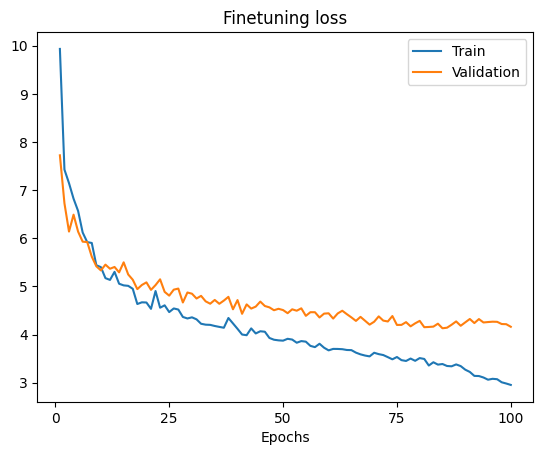

In [70]:
plt.figure()
xs = [i+1 for i in range(100)]
plt.plot(xs, train_losses, label="Train")
plt.plot(xs, val_losses, label="Validation")
plt.legend()
plt.xticks([i for i in range(0, 101, 25)])
plt.title("Finetuning loss")
plt.xlabel("Epochs")
plt.savefig("TrainValidationLosses.png")
plt.show()